In [103]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [104]:

# 加载IMDB数据集
# num_words=10000表示只保留最常见的10000个词，本身数据集有88582个词，如果未出现词，则用<UNK>表示
# 参数说明：
# - num_words: 保留的最常见词的数量
# - skip_top: 跳过最常见的若干词（通常是停用词）
# - maxlen: 序列最大长度
# - index_from: 词索引的起始值，默认为3；0,1,2,3标签id被[]使用
vocab_size=10000 # 保留最常用的10000个词
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size, index_from=3)

print(f"训练集样本数: {len(x_train)}, 测试集样本数: {len(x_test)}")
print(f"标签示例: {y_train[:10]}")  # 0表示负面评论，1表示正面评论

# 查看一个样本的词索引序列
print(f"一个样本的词索引序列: {x_train[0][:100]}...")


训练集样本数: 25000, 测试集样本数: 25000
标签示例: [1 0 0 1 0 0 1 0 1 0]
一个样本的词索引序列: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16]...


In [105]:
# 获取词索引映射，返回一个字典（词典），key是词，value是索引（token）
word_index = imdb.get_word_index() # 获取词索引映射

word_index = {word: idx + 3 for word, idx in word_index.items()}  # 0,1,2,3空出来做别的事,这里的idx是从1开始的,所以加3
word_index.update({
    "[PAD]": 0,  # 填充 token
    "[BOS]": 1,  # begin of sentence
    "[UNK]": 2,  # 未知 token
    "[EOS]": 3,  # end of sentence
})
# 创建索引到词的映射
reverse_word_index = {i: word for word, i in word_index.items()} #


In [106]:
word_index['the']

4

In [107]:
reverse_word_index[4]

'the'

In [108]:
# 将一个样本的索引序列转换为文本
def decode_review(indices):
    return ' '.join([reverse_word_index.get(i, '?') for i in indices])

print("\n解码后的样本文本:")
print(decode_review(x_train[0]))


解码后的样本文本:
[BOS] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [UNK] is an amazing actor and now the same being director [UNK] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [UNK] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [UNK] to the two little boy's that played the [UNK] of norman and paul they were just brilliant children are often left out of the [UNK] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praise

In [109]:
len(x_train[0])

218

In [110]:
# 将测试集划分为验证集和测试集
# 从原始测试集中取前10000个样本作为验证集
x_val = x_test[:10000]
y_val = y_test[:10000]

# 剩余的15000个样本作为测试集
x_test = x_test[10000:]
y_test = y_test[10000:]

print(f"验证集样本数: {len(x_val)}")
print(f"测试集样本数: {len(x_test)}")
print(f"验证集标签示例: {y_val[:10]}")
print(f"测试集标签示例: {y_test[:10]}")

验证集样本数: 10000
测试集样本数: 15000
验证集标签示例: [0 1 1 0 1 1 1 0 0 1]
测试集标签示例: [1 1 0 1 0 0 1 0 1 1]


In [111]:
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
raw_text #用.split()划分成列表

[['hello', 'world'],
 ['tokenize', 'text', 'datas', 'with', 'batch'],
 ['this', 'is', 'a', 'test']]

# 通过直方图来观察样本长度分布

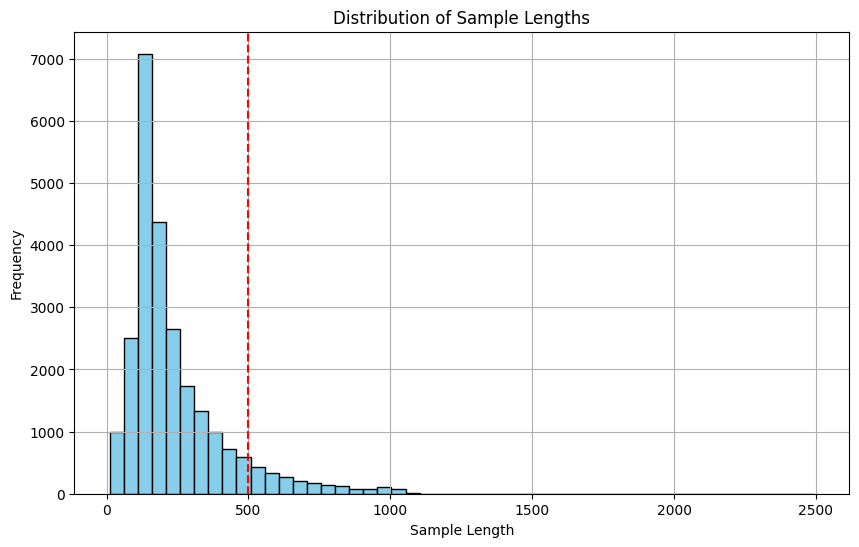

Number of samples with length <= 500: 22892 (91.57%)


In [112]:
import matplotlib.pyplot as plt

# 计算每个样本的长度
sample_lens = [len(sample) for sample in x_train]

# 绘制直方图
plt.figure(figsize=(10,6))
plt.hist(sample_lens, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=500, color='r', linestyle='--', label=f'500 Length')
plt.title('Distribution of Sample Lengths')  # 英文标题
plt.xlabel('Sample Length')  # 英文x轴
plt.ylabel('Frequency')      # 英文y轴

plt.grid(True)
plt.show()

# 统计长度小于等于500的样本数量以及百分比
count_le_500 = sum([1 for l in sample_lens if l <= 500])
percent_le_500 = count_le_500 / len(sample_lens) * 100  # 计算百分比
print(f"Number of samples with length <= 500: {count_le_500} ({percent_le_500:.2f}%)")  # 英文输出，带百分比


# Tokenizer

In [113]:
class Tokenizer:
    def __init__(self, word_index, reverse_word_index, max_len=None):
        """
        参数:
            word_index: dict, 词到索引的映射
            reverse_word_index: dict, 索引到词的映射
            max_len: int or None, 截断的最大长度（可选），用于encode和pad_sequence
        """
        # 根据file_context_1，初始化word2idx和idx2word
        # word_index 已经包含了所有词和特殊token的映射
        self.word2idx = word_index.copy()  # 词到索引的映射
        self.idx2word = reverse_word_index.copy()  # 索引到词的映射

        # 特殊token的索引
        self.pad_token = self.word2idx["[PAD]"]   # 填充token
        self.bos_token = self.word2idx["[BOS]"]   # 句子起始
        self.unk_token = self.word2idx["[UNK]"]   # 未知token
        self.end_token = self.word2idx["[END]"] if "[END]" in self.word2idx else self.word2idx.get("[EOS]", None)  # 句子结束（兼容旧词表）

        self.max_len = max_len  # 截断最大长度属性

    def fit(self, texts):
        """
        参数:
            texts: List[List[str]], 输入的分词文本列表
        功能:
            增量构建词表，避免覆盖已有特殊token
        """
        idx = max(self.word2idx.values()) + 1  # 从当前最大索引+1开始
        for sentence in texts:
            for word in sentence:
                if word not in self.word2idx:
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word
                    idx += 1
        # 中文注释：增量构建词表，避免覆盖已有特殊token

    def encode(self, sentence, add_bos=False, add_end=False, max_length=None, truncating='post'):
        """
        参数:
            sentence: List[str], 输入的分词句子
            add_bos: bool, 是否添加BOS
            add_end: bool, 是否添加END
            max_length: int or None, 截断的最大长度（优先于类属性）
            truncating: str, 'post'或'pre'，截断方式
        返回:
            tokens: List[int], 编码后的索引序列
        """
        tokens = []
        if add_bos:
            tokens.append(self.bos_token)  # 添加BOS
        for word in sentence:
            tokens.append(self.word2idx.get(word, self.unk_token))  # 未知词用UNK
        if add_end:
            tokens.append(self.end_token)  # 添加END

        # 截断逻辑
        use_maxlen = max_length if max_length is not None else self.max_len
        if use_maxlen is not None and len(tokens) > use_maxlen:
            if truncating == 'post':
                tokens = tokens[:use_maxlen]
            else:
                tokens = tokens[-use_maxlen:]
        # 中文注释：编码时可选加BOS/END，未知词用UNK，支持截断
        return tokens


    def decode(self, sequences, skip_special_tokens=True):
        """
        参数:
            sequences: List[int], 索引序列
            skip_special_tokens: bool, 是否跳过特殊token
        返回:
            words: List[str], 解码后的单词列表
        """
        result = []
        for sequence in sequences:
            words = []
            for idx in sequence:
                if idx == self.pad_token:
                    continue  # 跳过填充标记
                word = self.idx2word.get(idx, '?')
                # if word not in ['[PAD]', '[BOS]', '[UNK]', '[EOS]']:
                words.append(word)
            result.append(' '.join(words))
        return result

    def pad_sequence(self, sequences, maxlen=None, padding='post', truncating='post'):
        """
        参数:
            sequences: List[List[int]], 需要填充的索引序列列表
            maxlen: int or None, 填充/截断的最大长度（优先于类属性）
            padding: str, 'post'或'pre'，填充方式
            truncating: str, 'post'或'pre'，截断方式
        返回:
            padded: List[List[int]], 填充后的序列
        """
        # 中文注释：支持前/后填充和截断，默认后填充/截断
        use_maxlen = maxlen if maxlen is not None else self.max_len
        if use_maxlen is None:
            use_maxlen = max(len(seq) for seq in sequences)
        padded = []
        for seq in sequences:
            # 先截断
            if len(seq) > use_maxlen:
                if truncating == 'post':
                    seq = seq[:use_maxlen]
                else:
                    seq = seq[-use_maxlen:]
            # 再填充
            if len(seq) < use_maxlen:
                pad_length = use_maxlen - len(seq)
                if padding == 'post':
                    seq = seq + [self.pad_token] * pad_length
                else:
                    seq = [self.pad_token] * pad_length + seq
            padded.append(seq)
        return padded

    def vocab_size(self):
        """
        返回:
            int, 词表大小
        """
        return len(self.word2idx)

    def __len__(self):
        """
        返回:
            int, 词表大小
        """
        return self.vocab_size()

    def save_vocab(self, filepath):
        """
        参数:
            filepath: str, 保存词表的文件路径
        功能:
            保存词表到文件
        """
        with open(filepath, 'w', encoding='utf-8') as f:
            for word, idx in self.word2idx.items():
                f.write(f"{word}\t{idx}\n")
        # 中文注释：保存词表到文件

    def load_vocab(self, filepath):
        """
        参数:
            filepath: str, 词表文件路径
        功能:
            从文件加载词表
        """
        self.word2idx = {}
        self.idx2word = {}
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                word, idx = line.strip().split('\t')
                idx = int(idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word
        # 中文注释：从文件加载词表


In [114]:
# 创建Tokenizer实例，并进行测试
tokenizer = Tokenizer(word_index,reverse_word_index,max_len=500)  # 创建分词器实例

# 测试数据
texts = [
    ['hello', 'world'],
    ['tokenize', 'text', 'datas', 'with', 'batch'],
    ['this', 'is', 'a', 'test']
]

# 构建词表
tokenizer.fit(texts)

# 编码测试
encoded = [tokenizer.encode(sentence, add_bos=True, add_end=True) for sentence in texts]
print("Encoded sequences:", encoded)  # 输出编码后的序列


# 填充测试
padded = tokenizer.pad_sequence(encoded)
print("Padded sequences:", padded)  # 输出填充后的序列






Encoded sequences: [[1, 4825, 182, 3], [1, 88588, 3004, 88589, 19, 19233, 3], [1, 14, 9, 6, 2181, 3]]
Padded sequences: [[1, 4825, 182, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# 设置dataset 和 dataloader

In [115]:
import torch
from torch.utils.data import Dataset, DataLoader

# 定义自定义数据集类，包含输入文本、分词器和标签
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, labels=None):
        """
        texts: 原始文本数据（分词后的列表）
        tokenizer: 分词器对象
        labels: 标签列表
        """
        self.tokenizer = tokenizer  # 中文注释：保存分词器
        self.texts = tokenizer.decode(texts)       # 中文注释：保存原始文本
        self.labels = labels        # 中文注释：保存标签

        # 不进行编码和填充，直接保存原始分词文本
        # 中文注释：此处不再提前编码，保持原始词列表

    def __len__(self):
        # 中文注释：返回数据集的样本数量
        return len(self.texts)

    def __getitem__(self, idx):
        # 中文注释：返回指定索引的样本（词列表和标签）
        if self.labels is not None:
            return self.texts[idx], self.labels[idx]
        return self.texts[idx]

def collate_fn(batch, tokenizer, maxlen=500):
    """
    自定义批处理函数，用于在加载数据时进行编码
    
    参数:
    - batch: 批次数据
    - tokenizer: 分词器实例
    - maxlen: 最大序列长度
    
    返回:
    - 编码后的序列和标签（如果有的话）
    """
    if isinstance(batch[0], tuple):
        # print(batch)
        # 如果批次包含标签
        text_list = [item[0].split() for item in batch]  #batch是128样本，每个样本类型是元组，第一个元素是文本，第二个元素是标签
        label_list = [item[1] for item in batch]
        # print(text_list)
        encoded = tokenizer.encode(text_list, max_length=maxlen, truncating='post', add_bos=False, add_end=True)
        sequences = torch.tensor(encoded, dtype=torch.long)
        labels = torch.tensor(label_list, dtype=torch.float).view(-1, 1)  # 将标签reshape为二维 [batch_size, 1]
        return sequences, labels
    else:
        # 如果批次只有文本
        text_list = [item.split() for item in batch]
        encoded = tokenizer.encode(text_list, max_lenth=maxlen, truncating='post', add_bos=False, add_end=True)
        sequences = torch.tensor(encoded, dtype=torch.long)
        return sequences

# 示例：创建数据集
train_dataset = TextDataset(x_train, tokenizer, y_train)
val_dataset = TextDataset(x_val, tokenizer, y_val)
test_dataset = TextDataset(x_test, tokenizer, y_test)

# 创建数据加载器，collate_fn返回词而不是id
batch_size = 64
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    collate_fn=lambda batch: collate_fn(batch, tokenizer)
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    collate_fn=lambda batch: collate_fn(batch, tokenizer)
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    collate_fn=lambda batch: collate_fn(batch, tokenizer)
)


In [116]:

# 打印数据集和数据加载器信息（词而非id）
print(f"训练集大小: {len(train_dataset)}")  # 中文注释：打印训练集样本数
print(f"验证集大小: {len(val_dataset)}")   # 中文注释：打印验证集样本数
print(f"测试集大小: {len(test_dataset)}")  # 中文注释：打印测试集样本数

# 打印前3个样本的词内容
for i in range(3):
    if train_dataset.labels is not None:
        print(f"Sample {i}: Words: {train_dataset[i][0]}, Label: {train_dataset[i][1]}")  # 中文注释：输出词和标签
    else:
        print(f"Sample {i}: Words: {train_dataset[i]}")  # 中文注释：输出词
train_dataset[0:3]

训练集大小: 25000
验证集大小: 10000
测试集大小: 15000
Sample 0: Words: [BOS] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [UNK] is an amazing actor and now the same being director [UNK] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [UNK] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [UNK] to the two little boy's that played the [UNK] of norman and paul they were just brilliant children are often left out of the [UNK] list i think because the stars that play them all grown up are such a big profile for the whole film but th

(["[BOS] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [UNK] is an amazing actor and now the same being director [UNK] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [UNK] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [UNK] to the two little boy's that played the [UNK] of norman and paul they were just brilliant children are often left out of the [UNK] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [117]:
# 中文注释：enumerate()函数用于在遍历可迭代对象时，同时获取元素的索引和值
example_list = ['a', 'b', 'c']
for idx, value in enumerate(example_list):
    print(f"Index: {idx}, Value: {value}")  # 输出索引和值


Index: 0, Value: a
Index: 1, Value: b
Index: 2, Value: c


In [118]:

# 中文注释：遍历训练数据加载器
# 示例：遍历训练数据加载器
print("\n训练数据加载器示例:")
for i, (batch_sequences, batch_labels) in enumerate(train_dataloader):
    print(f"批次 {i+1}:")
    print(f"序列形状: {batch_sequences.shape}")
    print(f"标签形状: {batch_labels.shape}")
    if i == 0:  # 只打印第一个批次
        break
batch_sequences



训练数据加载器示例:


TypeError: unhashable type: 'list'